# Neuro-fuzzy Control - 1st Assignment - Function Approximation Neural Network

## Import Necessary Modules

In [32]:
import numpy as np
import matplotlib.pyplot as plt

import os
from os.path import join as pjoin

import scipy
import scipy.io as sio

from adabound import AdaBound

from tqdm.autonotebook import tqdm
import copy

import torch
from torch.utils.data import DataLoader
from pytorchUtils.Pipeline import RegressionPipeline as Pipeline

## Import and Visualize Data

In [33]:
PROJECT_PATH = os.getcwd()
DATA_PATH    = pjoin(PROJECT_PATH, 'data')
data         = sio.loadmat(pjoin(DATA_PATH, 'data_NN.mat'))['x_train']

In [34]:
%matplotlib widget

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

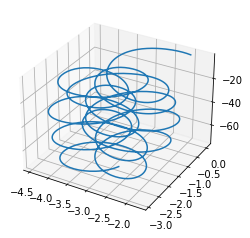

In [35]:
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.plot(data[0,:], data[1,:], data[2,:])

## Create the Dataset

In [36]:
def create_dataset(data, save_path='./', replace=False, test_data_ratio=0.25, info=True):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    if replace==False and \
       os.path.exists(pjoin(save_path, 'train_input_data.pt' )) and \
       os.path.exists(pjoin(save_path, 'train_output_data.pt')) and \
       os.path.exists(pjoin(save_path, 'test_input_data.pt'  )) and \
       os.path.exists(pjoin(save_path, 'test_output_data.pt' )):
        print("Files already exist, if you want to replace them then use replace=True")

        train_input_data  = torch.load(pjoin(save_path, 'train_input_data.pt' ))
        train_output_data = torch.load(pjoin(save_path, 'train_output_data.pt'))
        test_input_data   = torch.load(pjoin(save_path, 'test_input_data.pt'  ))
        test_output_data  = torch.load(pjoin(save_path, 'test_output_data.pt' ))

        return train_input_data, train_output_data, test_input_data, test_output_data

    # Create Input Output Data Points (pairs of consecutive 3D (xyz) points)
    input_data  = data.T[ :-1]
    output_data = data.T[1:  ]
    data_size   = input_data.shape[0]

    print(f"We have {data_size} samples")

    # Suffle Data
    suffled_index = np.random.choice(data_size, data_size, replace=False)
    s_input_data  = input_data[ suffled_index]
    s_output_data = output_data[suffled_index]

    # Train - Test Set Split
    test_data_size    = round(test_data_ratio*data_size)

    train_input_data  = torch.from_numpy(s_input_data[ :(-test_data_size)])
    train_output_data = torch.from_numpy(s_output_data[:(-test_data_size)])

    test_input_data   = torch.from_numpy(s_input_data[ (-test_data_size):])
    test_output_data  = torch.from_numpy(s_output_data[(-test_data_size):])

    # Save Data
    torch.save(train_input_data,  pjoin(DATA_PATH, 'train_input_data.pt' ))
    torch.save(train_output_data, pjoin(DATA_PATH, 'train_output_data.pt'))
    torch.save(test_input_data,   pjoin(DATA_PATH, 'test_input_data.pt'  ))
    torch.save(test_output_data,  pjoin(DATA_PATH, 'test_output_data.pt' ))

    return train_input_data, train_output_data, test_input_data, test_output_data

(train_input_data, train_output_data, 
 test_input_data,  test_output_data  ) = create_dataset(data, test_data_ratio=0.3,
                                                        save_path=DATA_PATH, replace=True)

We have 1000 samples


## Create Dataset Class

In [37]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, input_data=None, output_data=None, path=None, train=True, in_transform=None, out_transform=None):
        if path is not None:
            # check if path exists
            if not os.path.exists(path):
                raise ValueError("Path does not exist")

            # if not test load train dataset
            dset_type = "train" if train else "test"

            self.data    = torch.load(pjoin(path, dset_type+"_input_data.pt"))
            self.targets = torch.load(pjoin(path, dset_type+"_output_data.pt"))
        else:
            # check if both are set
            if input_data is None or output_data is None:
                raise TypeError("input_data and output_data should not be None")
            # check if they are of same size
            if len(input_data) != len(output_data):
                raise ValueError("input_data and output_data should be of same length")

            self.data    = input_data
            self.targets = output_data

        # save the desired transforms to apply to each data sample
        self.in_transform  = in_transform
        self.out_transform = out_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_point  = self.data[idx]
        output_point = self.targets[idx]

        # apply any transform desired
        if self.in_transform:
            input_point  = self.in_transform(input_point)

        if self.out_transform:
            output_point = self.out_transform(output_point)

        return [input_point, output_point]

## Create the Model

In [38]:
class OneHiddenLayerNet(torch.nn.Module):
    def __init__(self, neurons):
        super().__init__()
        self.linear1 = torch.nn.Linear(3, neurons)
        self.linear2 = torch.nn.Linear(neurons, 3)

    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        output = self.linear2(h_relu)

        return output

class TwoHiddenLayerNet(torch.nn.Module):
    def __init__(self, H1, H2):
        super().__init__()
        self.linear1 = torch.nn.Linear(3, H1)
        self.linear2 = torch.nn.Linear(H1, H2)
        self.linear3 = torch.nn.Linear(H2, 3)

    def forward(self, x):
        h1_relu = self.linear1(x).clamp(min=0)
        h2_relu = self.linear2(h1_relu).clamp(min=0)
        output  = self.linear3(h2_relu)

        return output

## Create Test/Train Sets and Loaders - Normalize Data

In [86]:
def standarize(tensor, mean, std, scale=1):
    # make it have mean = 0 and std = 1
    return scale*(tensor - mean)/std

def destandarize(tensor, mean, std, scale=1):
    # restore it from having mean = 0 and std = 1
    return tensor*std/scale + mean

def normalize(tensor, minim, maxim, scale=1):
    # make it be between 0 and 1
    return scale*(tensor - minim)/(maxim - minim)

def denormalize(tensor, minim, maxim, scale=1):
    # restore it from being between 0 and 1
    return tensor*(maxim - minim)/scale + minim

input_mean = train_input_data.mean(axis=0)
input_std  = train_input_data.std( axis=0)
input_min  = train_input_data.min( axis=0)[0]
input_max  = train_input_data.max( axis=0)[0]

output_mean = train_output_data.mean(axis=0)
output_std  = train_output_data.std( axis=0)
output_min  = train_output_data.min( axis=0)[0]
output_max  = train_output_data.max( axis=0)[0]

in_transform    = lambda x: normalize(   x, input_min,   input_max)
# in_transform    = lambda x: standarize(  x, input_mean,  input_std)
out_transform   = lambda x: normalize(   x, output_min,  output_max, scale=20)
out_detransform = lambda x: denormalize( x, output_min,  output_max, scale=20)
# out_transform   = lambda x: standarize(  x, output_mean, output_std)
# out_detransform = lambda x: destandarize(x, output_mean, output_std)
# in_transform    = lambda x: x
# out_transform   = lambda x: x
# out_detransform = lambda x: x

trainset    = Dataset(train_input_data, train_output_data, in_transform=in_transform, out_transform=out_transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset     = Dataset(test_input_data,  test_output_data,  in_transform=in_transform, out_transform=out_transform)
testloader  = DataLoader(testset,  batch_size=64, shuffle=True)

## Setup the Pipeline and Train

In [146]:
input_data  = torch.from_numpy(data.T[ :-1])
output_data = data.T[1:  ]

def eval_fun(model, init_point, output_data, device, in_transform, out_detransform, points_num=200):
    model.eval()

    c_data_point = init_point
    full_predicted_output = torch.zeros(points_num, 3)

    for i in range(points_num):
        norm_input   = in_transform(c_data_point)
        c_data_point = out_detransform(model(norm_input.to(device)).cpu().detach())
        full_predicted_output[i] = c_data_point
    full_predicted_output = full_predicted_output.cpu().detach().numpy()

    return np.square(full_predicted_output - output_data[:points_num]).mean() #MSE

In [129]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model  = OneHiddenLayerNet(8)
model.double()
model.to(device)

criterion = torch.nn.MSELoss() # loss function -- Mean Square Error
optimizer = AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)

minmse     = np.inf
all_mse    = []
best_model = None

In [130]:
%matplotlib inline

In [131]:
ppln = Pipeline(model, device, optimizer, criterion, trainloader, testloader, testloader, live_plot=False, hide_sub_bars=True, hide_all_bars=True)

In [132]:
progress = tqdm(range(300), desc="MSE:", unit='epochs', ncols='100%')

for _ in progress:
    _   = ppln.training(epochs=1, show_training_stats=False)
    mse = eval_fun(model, input_data[0], output_data, device, in_transform, out_detransform)
    all_mse.append(mse)
    if mse <= minmse:
        minmse = mse
        epoch  = ppln.epochs
        best_model = copy.deepcopy(model)
    progress.set_description(f"MSE: {mse:.3f}")

In [186]:
print(f"In {epoch} epoch we found the minimum MSE which is {minmse:.4f}")

In 151 epoch we found the minimum MSE which is 0.8993


## Calculate Test Set Error

MSE for our test set is: 0.0023


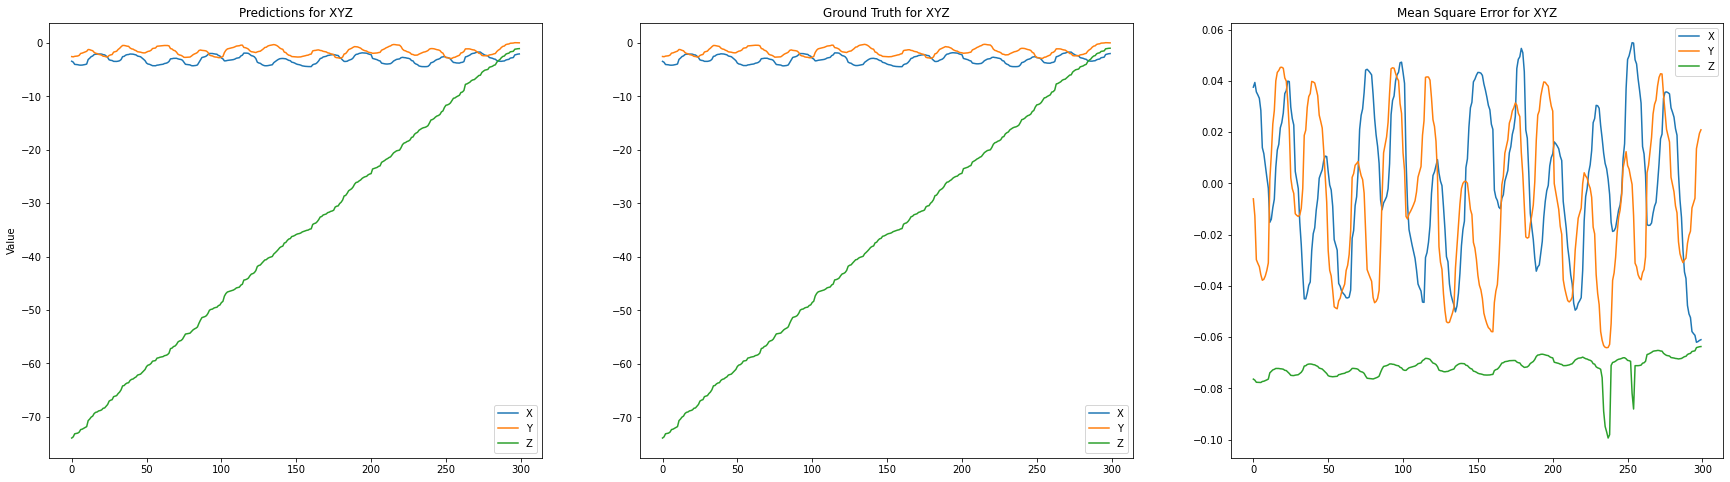

In [201]:
testloadertest = DataLoader(testset,  batch_size=len(testset))
model.eval()
test_data_out = best_model(next(iter(testloadertest))[0].to(device)).cpu().detach()
test_data_out = out_detransform(test_data_out)

fig, (pred, orig, err) = plt.subplots(1, 3, figsize=(30,8))
pred.plot(test_data_out[test_data_out[:,2].argsort()])
pred.legend(['X', 'Y', 'Z'])
pred.set_ylabel('Value')
pred.set_title('Predictions for XYZ')
orig.plot(testset.data[testset.data[:,2].argsort()])
orig.legend(['X', 'Y', 'Z'])
orig.set_title('Ground Truth for XYZ')
err.plot(test_data_out[test_data_out[:,2].argsort()] - testset.data[testset.data[:,2].argsort()])
err.legend(['X', 'Y', 'Z'])
err.set_title('Mean Square Error for XYZ')

print(f"MSE for our test set is: {np.square(test_data_out - testset.data).mean():.4f}")

## Experiment

In [49]:
# def minus_one_one_normalize(tensor, minim, maxim, scale=1):
#     # make it be between -1 and 1
#     return 2*scale*(tensor - minim)/(maxim - minim) - 1

# def minus_one_one_denormalize(tensor, minim, maxim, scale=1):
#     # restore it from being between -1 and 1
#     return (tensor + 1)*(maxim - minim)/(2*scale) + minim

In [50]:
# no_transf = lambda x: x

# norm_in   = lambda x: normalize(  x, input_min,  input_max)
# stan_in   = lambda x: standarize( x, input_mean, input_std)

# norm_out  = lambda x: normalize(  x, output_min, output_max)
# stan_out  = lambda x: standarize( x, output_mean, output_std)

# norm_out_scld = lambda x: normalize( x, output_min,  output_max, scale=10)
# stan_out_scld = lambda x: standarize(x, output_mean, output_std, scale=10)

# sp_norm_out        = lambda x: minus_one_one_normalize(  x, output_min, output_max)
# sp_denorm_out      = lambda x: minus_one_one_denormalize(x, output_min, output_max)
# sp_norm_out_scld   = lambda x: minus_one_one_normalize(  x, output_min, output_max, scale=5)
# sp_denorm_out_scld = lambda x: minus_one_one_denormalize(x, output_min, output_max, scale=5)

# denorm_out = lambda x: denormalize( x, output_min,  output_max)
# destan_out = lambda x: destandarize(x, output_mean, output_std)

# denorm_out_scld = lambda x: denormalize( x, output_min,  output_max, scale=10)
# destan_out_scld = lambda x: destandarize(x, output_mean, output_std, scale=10)

# in_trnfrms    = [norm_in, stan_in]
# out_trnfrms   = [no_transf, norm_out, norm_out_scld, stan_out, stan_out_scld, sp_norm_out, sp_norm_out_scld]
# out_detrnfrms = [no_transf, denorm_out, denorm_out_scld, destan_out, destan_out_scld, sp_denorm_out, sp_denorm_out_scld]

# in_trnfrms_names   = ['normalize']
# out_trnfrms_name   = [  'normalize - scaled', '-1,1 normalize - scaled']
# out_detrnfrms_name = ['denormalize - scaled', '-1,1 denormalize - scaled']

# best_models = []
# best_mses   = []
# all_mses    = []
# best_mses_epochs = []

# from itertools import product

# for (in_transform, (out_transform, out_detransform)), (in_transform_name, (out_transform_name, out_detransform_name)) in zip(product(in_trnfrms,       zip(out_trnfrms, out_detrnfrms)),
#                                                                                                                              product(in_trnfrms_names, zip(out_trnfrms_name,out_detrnfrms_name))):
#     print(f"Input Transform: {in_transform_name}, Output Transform: {out_transform_name}, Output de-Transform: {out_detransform_name}")
#     trainset    = Dataset(train_input_data, train_output_data, in_transform=in_transform, out_transform=out_transform)
#     trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

#     testset     = Dataset(test_input_data,  test_output_data,  in_transform=in_transform, out_transform=out_transform)
#     testloader  = DataLoader(testset,  batch_size=64, shuffle=True)

#     model  = OneHiddenLayerNet(8)
#     model.double()
#     model.to(device)

#     criterion = torch.nn.MSELoss() # loss function -- Mean Square Error

#     optimizer = AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)
#     # optimizer = torch.optim.SGD(model.parameters(), lr=3e-3, momentum=0.7)

#     minmse     = np.inf
#     all_mse    = []
#     best_model = None

#     ppln = Pipeline(model, device, optimizer, criterion, trainloader, testloader, testloader, live_plot=False, hide_all_bars=True)
#     progress = tqdm(range(300), desc="MSE:", unit='epochs', ncols='100%')

#     for _ in progress:
#         _   = ppln.training(epochs=1, show_traning_stats=False)
#         mse = eval_fun(model, input_data[0], output_data, device, in_transform, out_detransform)
#         all_mse.append(mse)
#         if mse <= minmse:
#             minmse = mse
#             epoch  = ppln.epochs
#             best_model = copy.deepcopy(model)
#         progress.set_description(f"MSE: {mse:.3f}")

#     best_models.append(best_model)
#     best_mses.append(minmse)
#     all_mses.append(all_mse)
#     best_mses_epochs.append(epoch)
#     print(f"Minimum MSE is {minmse} in {epoch} epochs")

In [326]:
# print("+-----------------+-------------------------++----------+----------------+------------------------+-----------------------+")
# print("| Input Transform | Output Transform        || Best MSE | Best MSE Epoch | Mean MSE (of 140 best) | std MSE (of 140 best) |")
# print("|-----------------+-------------------------++----------+----------------+------------------------+-----------------------|")

# for idx, ((in_transform, (out_transform, out_detransform)), (in_transform_name, out_transform_name)) in enumerate(zip(product(in_trnfrms,       zip(out_trnfrms, out_detrnfrms)),
#                                                                                                                       product(in_trnfrms_names, out_trnfrms_name)
#                                                                                                                      )
#                                                                                                                  ):
#     print(f"| {in_transform_name:<15} | {out_transform_name:<23} || {best_mses[idx]:8.4f} | {best_mses_epochs[idx]:14} | {np.sort((np.array(all_mses[idx])))[:140].mean():22.3f} | {np.sort((np.array(all_mses[idx])))[:140].std():21.3f} |")
# print("+-----------------+-------------------------++----------+----------------+------------------------+-----------------------+")

+-----------------+-------------------------++----------+----------------+------------------------+-----------------------+
| Input Transform | Output Transform        || Best MSE | Best MSE Epoch | Mean MSE (of 140 best) | std MSE (of 140 best) |
|-----------------+-------------------------++----------+----------------+------------------------+-----------------------|
| normalize       | no transform            ||   0.8531 |            287 |                 67.296 |                87.150 |
| normalize       | normalize               ||   4.6417 |            290 |                 46.745 |                43.368 |
| normalize       | normalize - scaled      ||   0.6054 |            214 |                 19.521 |                13.943 |
| normalize       | standarize              ||   6.9114 |            212 |                 27.019 |                13.085 |
| normalize       | standarize - scaled     ||   0.7570 |            178 |                113.288 |                83.338 |
| normal

## Visualize Pair Predictions

In [183]:
fullset    = Dataset(input_data, output_data, in_transform=in_transform)
fullloader = DataLoader(fullset, batch_size=len(fullset))

predicted_output_data = best_model(next(iter(fullloader))[0].to(device)).cpu().detach()
predicted_output_data = out_detransform(predicted_output_data)

MSE for all the predictions is 0.0009 and is distributed as:
    	• X axis: 0.0012
    	• Y axis: 0.0012
    	• Z axis: 0.0003


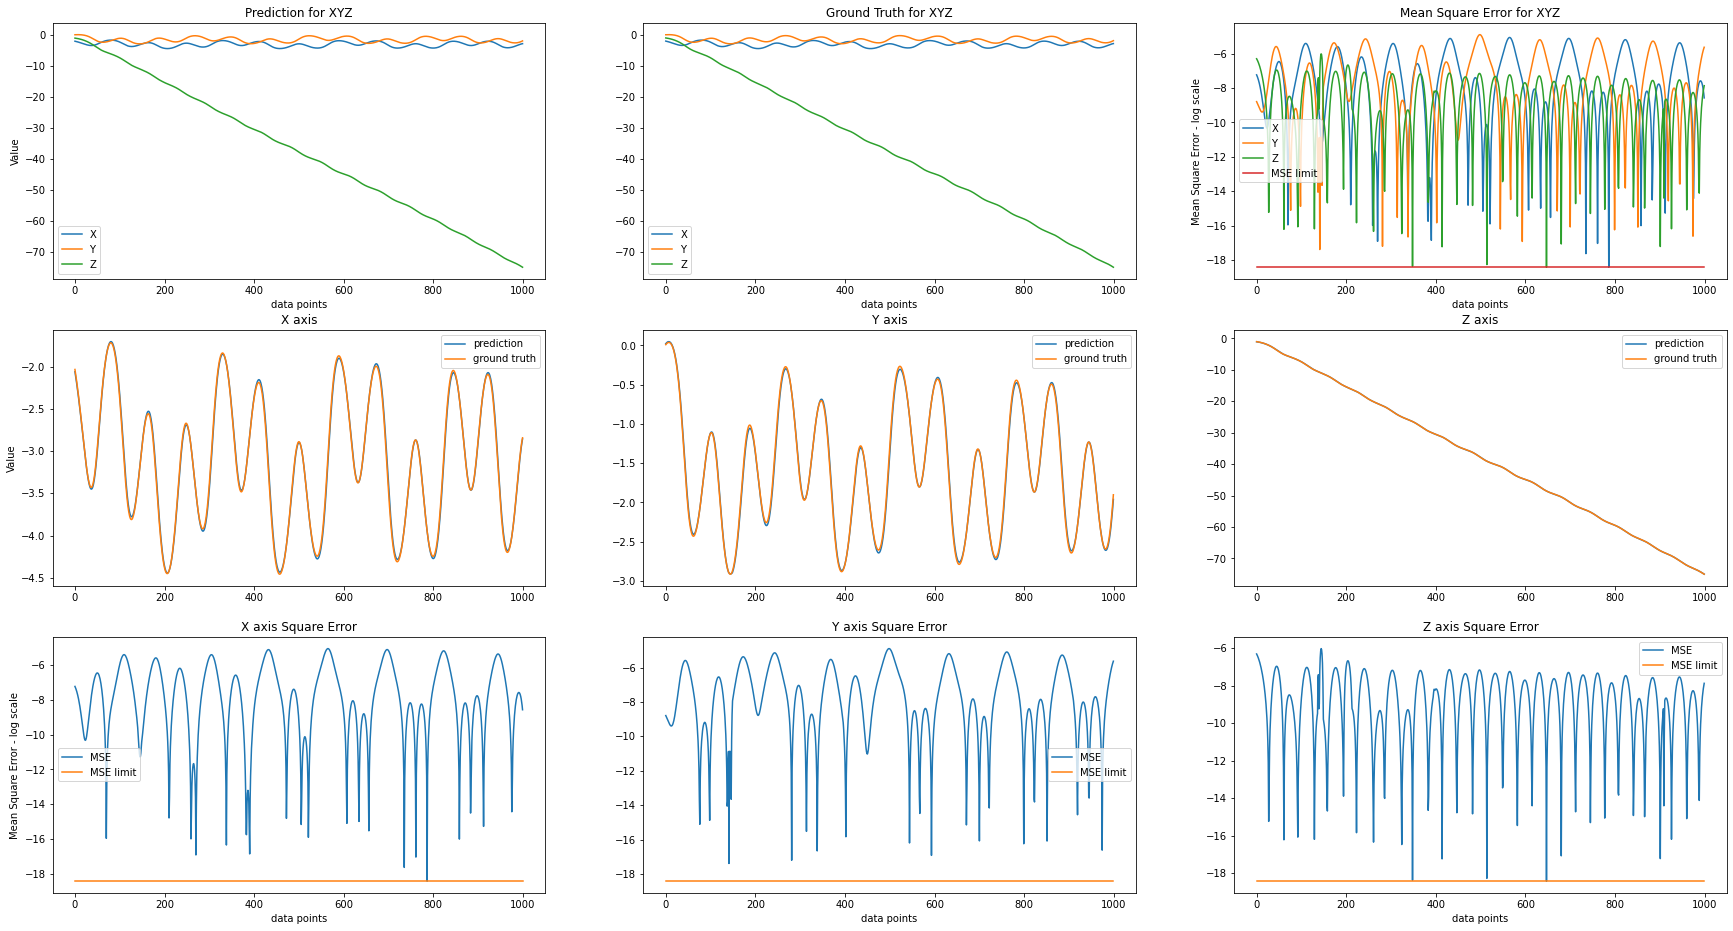

In [153]:
def print_MSE_stats(pred, orig):
    MSE = (np.square(pred - orig)).mean(axis=0)

    print(f"""MSE for all the predictions is {MSE.mean():.4f} and is distributed as:
    \t\u2022 X axis: {MSE[0]:.4f}
    \t\u2022 Y axis: {MSE[1]:.4f}
    \t\u2022 Z axis: {MSE[2]:.4f}""")

def plot_pred_orig_sqErr(pred_dt, orig_dt, err_log_scale = True):
    if err_log_scale:
        scale = np.log
    else:
        scale = lambda x: x

    fig, ((pred, orig, err), (x, y, z), (xe, ye, ze)) = plt.subplots(3, 3, figsize=(30, 16))

    err_dt = scale((pred_dt - orig_dt)**2 + (1e-8 if err_log_scale else 0))

    for idx, (ax, data, title_str) in enumerate(zip([pred, orig, err], [pred_dt, orig_dt, err_dt], ['Prediction', 'Ground Truth', 'Mean Square Error'])):
        ax.plot(data)
        ax.set_title(title_str+' for XYZ')
        ax.set_xlabel('data points')
        ax.legend(['X', 'Y', 'Z'])
    pred.set_ylabel('Value')
    err.set_ylabel('Mean Square Error')

    for idx, (ax, axis_str) in enumerate(zip([x, y, z], ['X', 'Y', 'Z'])):
        ax.plot(pred_dt[:, idx])
        ax.plot(orig_dt[:, idx])
        ax.legend(['prediction', 'ground truth'])
        ax.set_title(axis_str+' axis')
    x.set_ylabel('Value')

    for idx, (ax, axis_str) in enumerate(zip([xe, ye, ze], ['X', 'Y', 'Z'])):
        ax.plot(err_dt[:, idx])
        ax.set_title(axis_str+' axis Square Error')
        ax.set_xlabel('data points')
    xe.set_ylabel('Mean Square Error')

    if err_log_scale:
        xe.set_ylabel('Mean Square Error - log scale')
        err.set_ylabel('Mean Square Error - log scale')
        err.plot(scale(np.zeros_like(err_dt[:, 0]) + 1e-8))
        err.legend(['Χ', 'Υ', 'Ζ', 'MSE limit'])

        for idx,ax in enumerate([xe, ye, ze]):
            ax.plot(scale(np.zeros_like(err_dt[:, idx]) + 1e-8))
            ax.legend(['MSE', 'MSE limit'])

print_MSE_stats(predicted_output_data, output_data)
plot_pred_orig_sqErr(predicted_output_data, output_data)

plt.savefig('easy_pred_error', bbox_inches='tight')

## Visualize Full Prediction From "first" Point

In [154]:
c_data_point = input_data[0]
full_predicted_output = torch.zeros(1000, 3)

for i in range(1000):
    norm_input   = in_transform(c_data_point)
    c_data_point = out_detransform(best_model(norm_input.to(device)).cpu().detach())
    full_predicted_output[i] = c_data_point
full_predicted_output = full_predicted_output.cpu().detach().numpy()

MSE for all the predictions is 0.8993 and is distributed as:
    	• X axis: 1.3334
    	• Y axis: 1.1360
    	• Z axis: 0.2284


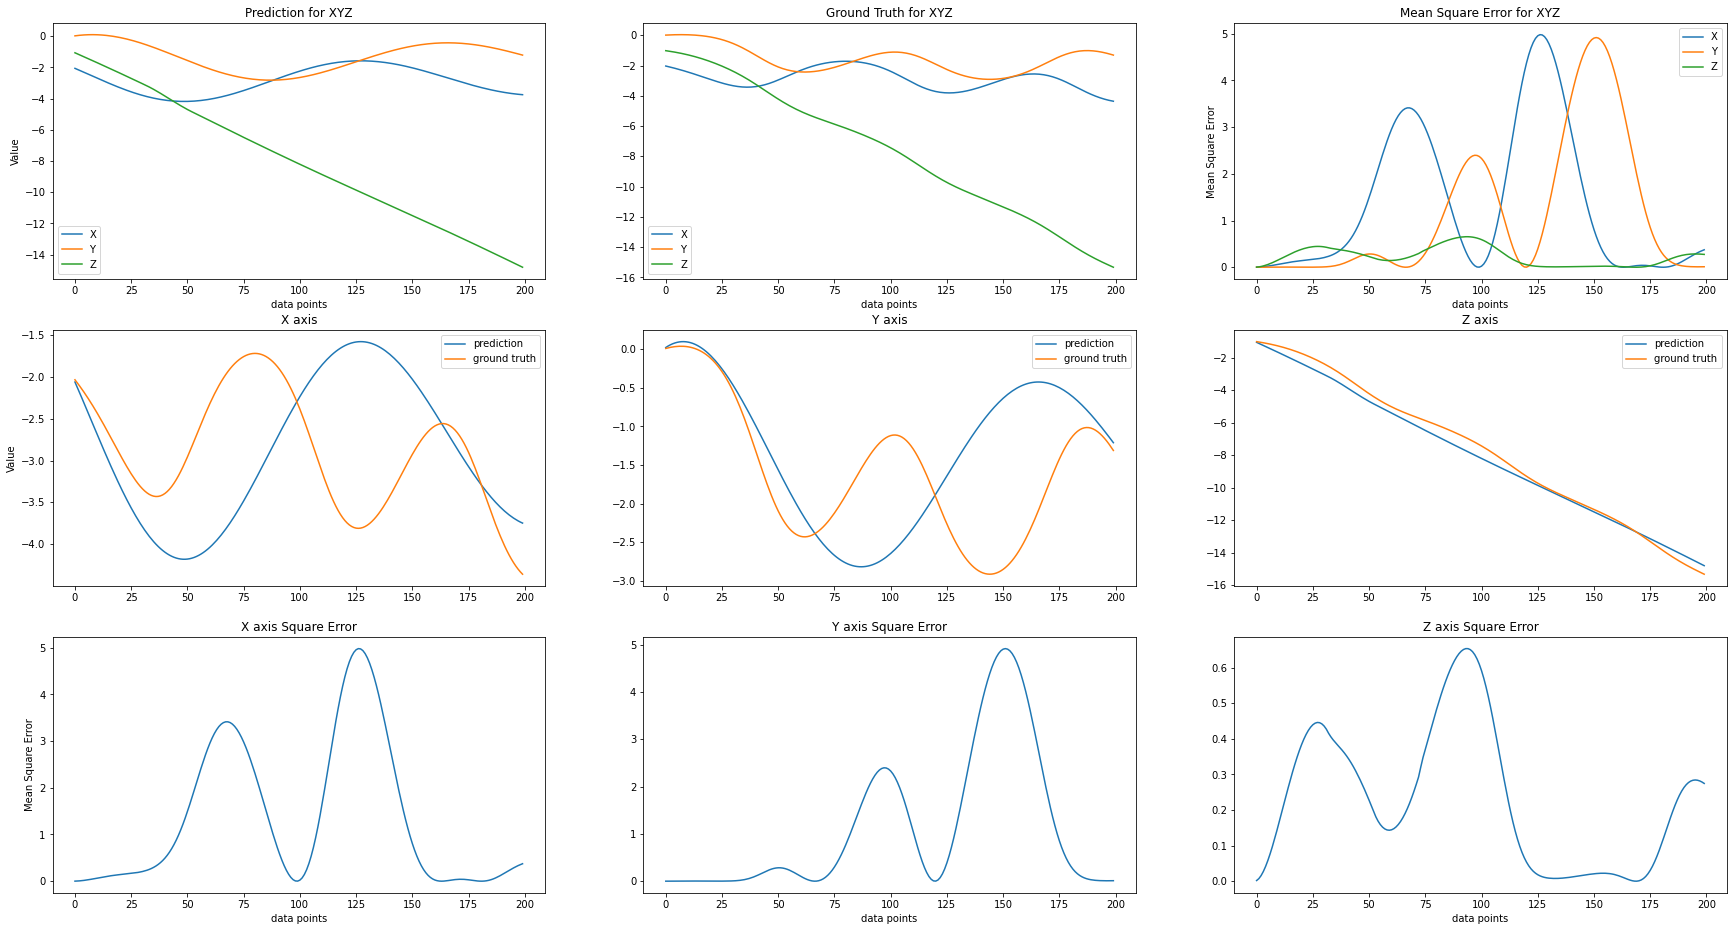

In [156]:
print_MSE_stats(full_predicted_output[:200], output_data[:200])
plot_pred_orig_sqErr(full_predicted_output[:200], output_data[:200], err_log_scale=False)

## Visualize Full Prediction From Slightly Different "first" Point

In [160]:
c_data_point = torch.tensor([-1.9, 0, -0.9], dtype=torch.float64)
new_full_predicted_output = torch.zeros(1000, 3)

for i in range(1000):
    norm_input   = in_transform(c_data_point)
    c_data_point = out_detransform(best_model(norm_input.to(device)).cpu().detach())
    new_full_predicted_output[i] = c_data_point
new_full_predicted_output = new_full_predicted_output.cpu().detach().numpy()

MSE for all the predictions is 0.9738 and is distributed as:
    	• X axis: 1.3904
    	• Y axis: 1.1513
    	• Z axis: 0.3798


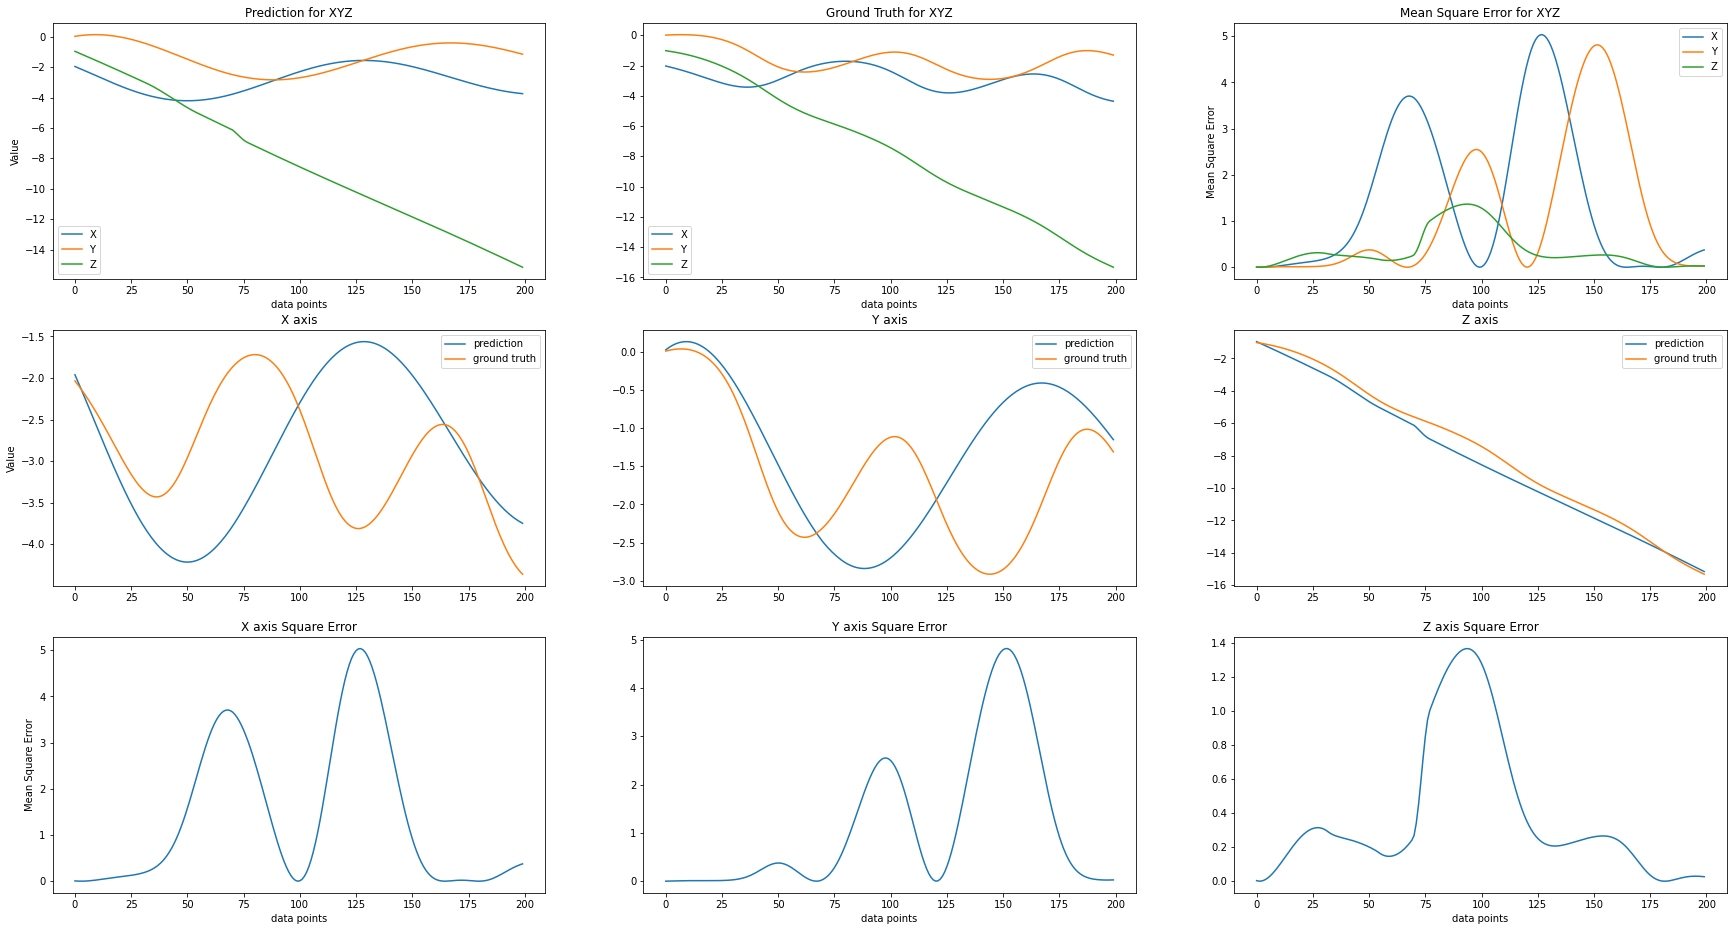

In [161]:
print_MSE_stats(new_full_predicted_output[:200], output_data[:200])
plot_pred_orig_sqErr(new_full_predicted_output[:200], output_data[:200], err_log_scale=False)

plt.savefig('diff_pred_error', bbox_inches='tight')

In [159]:
sio.savemat(pjoin(DATA_PATH, 'pred_out.mat'), {"pred_out": new_full_predicted_output[:200].T})